In [1]:
from jax import random, numpy as jnp
import jax.scipy.stats as st
import ploo


class GaussianModel(ploo.Model):
    name = "Gaussian mean model"

    def __init__(self, y):
        self.y = y
        self.folds = jnp.arange(0, len(y))

    def log_likelihood(self, model_params, cv_fold):
        ll = st.norm.logpdf(self.y, loc=model_params["mu"], scale=1.0)
        return jnp.where(self.folds != cv_fold, ll, 0).sum()

    def log_prior(self, model_params):
        return st.norm.logpdf(model_params["mu"], loc=0.0, scale=1.0)

    def log_cond_pred(self, model_params, cv_fold):
        y_tilde = self.y[cv_fold]
        return st.norm.logpdf(y_tilde, loc=model_params["mu"], scale=1.0)

    def initial_value(self):
        return {"mu": 0.0}

    def cv_folds(self):
        return len(self.y)

    @classmethod
    def generate(cls, N, mu, seed):
        rng_key = random.PRNGKey(seed=seed)
        return mu + random.normal(rng_key, shape=(N,))

In [2]:
# generate some data
y = GaussianModel.generate(N=200, mu=2.5, seed=42)
# fit full-data model
model = GaussianModel(y)
posterior = model.inference()

Thor's Cross-Validatory Hammer

Starting Stan warmup using NUTS...
      500 warmup draws took 4.3 sec (116.2 iter/sec).
Running full-data inference with 8 chains...
      16,000 HMC draws took 2.2 sec (7,352 iter/sec).


In [3]:
posterior.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.614,0.071,2.486,2.75,0.001,0.0,10785.0,12048.0,1.0


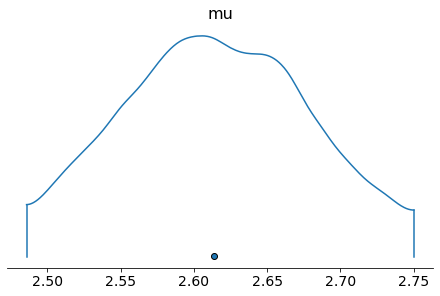

In [4]:
posterior.plot_density();

In [5]:
cv = posterior.cross_validate()

Cross-validation with 200 folds using 1,600 chains...
      3,200,000 HMC draws took 2.9 sec (1,104,941 iter/sec).


In [6]:
cv

Cross-validation summary

    elpd = -1.3273 (se 0.0131)

Calculated from 200 folds (8 chains per fold, 1,600 total)

Average acceptance rate 83.1% (min 79.9%, max 86.2%)

Divergent chain count: 0